In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier

# Train/test split & preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [ ]:
# Load datasets
train = pd.read_csv("/content/drive/MyDrive/data_minihackathon_train.csv")
test  = pd.read_csv("/content/drive/MyDrive/data_minihackathon_test.csv")

In [ ]:
train.head()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,drug_category
0,1,1.09449,-0.48246,-0.05921,0.24923,-0.31685,0.13606,-1.09207,-0.45174,-1.21213,-0.00665,-0.21712,0.76540,Depressants
1,2,-0.95197,-0.48246,-0.61113,-0.57009,-0.31685,-0.14882,-0.15487,1.24033,0.94156,-0.14277,0.88113,1.92173,Hallucinogens
2,3,-0.07854,0.48246,1.16365,NaN,-0.22166,0.82562,-0.57545,-1.97495,-0.91699,0.25953,0.52975,1.22470,Stimulants
3,4,-0.95197,-0.48246,0.45468,-0.57009,-0.31685,0.22393,-1.23177,0.29338,-0.45321,-1.13788,0.19268,-1.18084,Hallucinogens
4,5,0.49788,0.48246,1.16365,0.96082,-0.31685,0.13606,-0.15487,-0.45174,0.76096,-0.27607,0.88113,1.22470,Depressants


##Checking for Null values

In [ ]:
train.isnull().sum()


,0
ID,0
Age,2
Gender,1
Education,20
Country,2
Ethnicity,0
Nscore,1
Escore,1
Oscore,1
Ascore,1


In [ ]:
test.isnull().sum()

,0
ID,0
Age,1
Gender,0
Education,5
Country,0
Ethnicity,0
Nscore,1
Escore,0
Oscore,2
Ascore,0


##Handleing Null values

In [ ]:
# Fill numeric nulls with median
numeric_cols = train.select_dtypes(include=np.number).columns.tolist()
for col in numeric_cols:
    median = train[col].median()
    train[col] = train[col].fillna(median)
    if col in test.columns:
        test[col] = test[col].fillna(median)

# Fill categorical nulls with mode
cat_cols = ['Gender','Education','Country','Ethnicity']
for col in cat_cols:
    mode = train[col].mode()[0]
    train[col] = train[col].fillna(mode)
    if col in test.columns:
        test[col] = test[col].fillna(mode)

In [ ]:
test.isnull().sum()

,0
ID,0
Age,0
Gender,0
Education,0
Country,0
Ethnicity,0
Nscore,0
Escore,0
Oscore,0
Ascore,0


In [ ]:
train.isnull().sum()

,0
ID,0
Age,0
Gender,0
Education,0
Country,0
Ethnicity,0
Nscore,0
Escore,0
Oscore,0
Ascore,0


##EDA

In [ ]:
train.shape


(1500, 14)

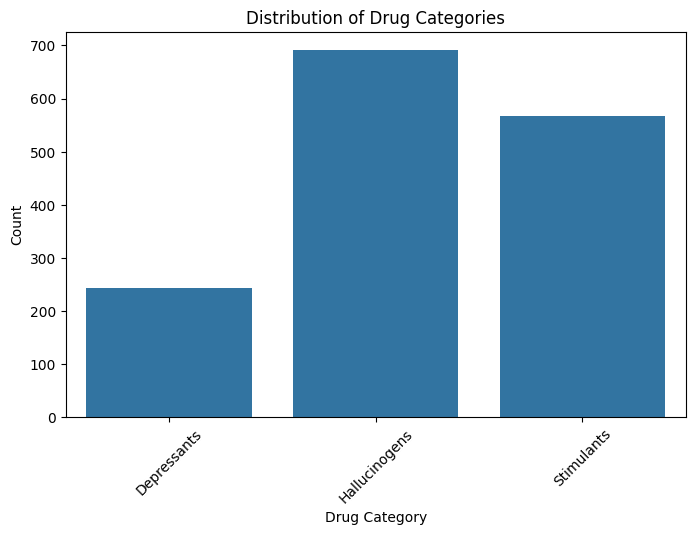

In [ ]:

plt.figure(figsize=(8,5))
sns.countplot(data=train, x='drug_category')
plt.title("Distribution of Drug Categories")
plt.xlabel("Drug Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


This shows  a clear imbalance across drug categories.

This indicates that:

- Hallucinogen users are the largest group, representing nearly half the samples.

- Stimulant users form the second largest class, slightly smaller but still substantial.

- Depressant users are the minority class, with only ~250 samples.

Insight:

The dataset exhibits moderate class imbalance, especially for the Depressants category.
Because of this imbalance, classification models may be biased toward predicting the more frequent categories (hallucinogens and stimulants).

<Axes: >

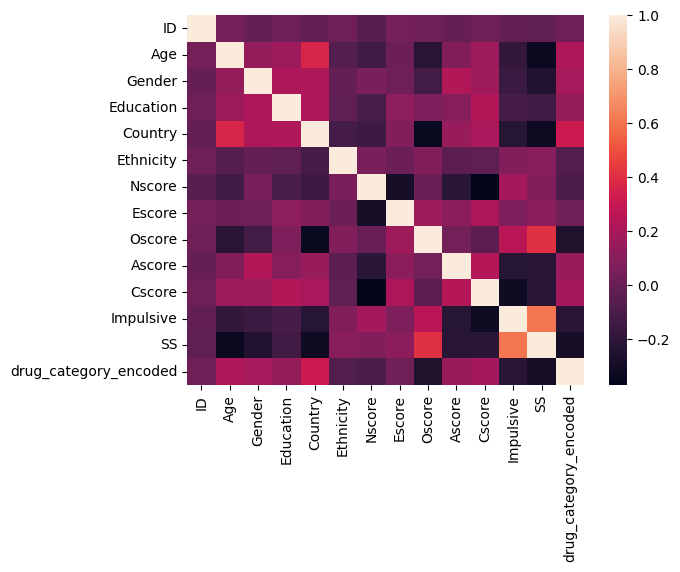

In [ ]:
le = LabelEncoder()
train['drug_category_encoded'] = le.fit_transform(train['drug_category'])

sns.heatmap(train.drop('drug_category', axis=1).corr(numeric_only=True), annot=False)

In [ ]:
le = LabelEncoder()
y = le.fit_transform(train['drug_category'])


In [ ]:
X = train.drop(columns=['ID', 'drug_category', 'drug_category_encoded'])
X_test = test.drop(columns=['ID'])

# Add interaction / polynomial features
for df in [X, X_test]:
    df['Impulsive_SS'] = df['Impulsive'] * df['SS']
    df['Nscore_Escore'] = df['Nscore'] * df['Escore']
    df['Impulsive_squared'] = df['Impulsive'] ** 2
    df['SS_squared'] = df['SS'] ** 2


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# ---------------------------
# 1. Compute Class Weights
# ---------------------------
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)

print("Class Weights:", class_weights)

# ---------------------------
# 2. Cross-Validation Setup
# ---------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ---------------------------
# 3. XGBoost (no class weights needed for moderate imbalance)
# ---------------------------
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.05,
    reg_alpha=0.1,
    reg_lambda=1.2,
    random_state=42,
    eval_metric='mlogloss'
)

xgb_cv = cross_val_score(xgb_model, X, y, cv=skf, scoring='accuracy')
print(f"XGBoost CV Accuracy: {xgb_cv.mean():.4f} ± {xgb_cv.std():.4f}")

# ---------------------------
# 4. Random Forest (use class_weight)
# ---------------------------
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight='balanced',   # <--- imbalance handled here
    random_state=42
)

rf_cv = cross_val_score(rf_model, X, y, cv=skf, scoring='accuracy')
print(f"Random Forest CV Accuracy: {rf_cv.mean():.4f} ± {rf_cv.std():.4f}")

# ---------------------------
# 5. CatBoost (pass computed class_weights)
# ---------------------------
cat_model = CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.03,
    loss_function='MultiClass',
    class_weights=class_weights.tolist(),    # <--- imbalance handled here
    random_seed=42,
    verbose=False
)

cat_cv = cross_val_score(cat_model, X, y, cv=skf, scoring='accuracy')
print(f"CatBoost CV Accuracy: {cat_cv.mean():.4f} ± {cat_cv.std():.4f}")


Class Weights: [2.0661157  0.723589   0.88183422]
XGBoost CV Accuracy: 0.7107 ± 0.0176
Random Forest CV Accuracy: 0.7093 ± 0.0134
CatBoost CV Accuracy: 0.6787 ± 0.0228


## Train final model with training data

In [ ]:
xgb_model.fit(X, y)
rf_model.fit(X, y)
cat_model.fit(X, y)

In [ ]:
ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('cat', cat_model),
        ('rf', rf_model)
    ],
    voting='soft',
    weights=[0.4, 0.4, 0.2]
)


In [ ]:
ensemble.fit(X, y)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=0.05,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_co...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7c3b41257c50>),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=10,
                                                     n_estimators=300,
                                                     random_state=42))],
                 voting='soft', weights=[0.4, 0.4, 0.2])

In [ ]:
test_preds = ensemble.predict(X_test)


In [ ]:

# Inverse transform predicted labels back to original text labels
final_predictions = le.inverse_transform(test_preds)

# Build submission DataFrame
submission = pd.DataFrame({
    "ID": range(501, 501 + len(final_predictions)),
    "drug_category": final_predictions
})

submission.head()


,ID,drug_category
0,501,Stimulants
1,502,Stimulants
2,503,Stimulants
3,504,Hallucinogens
4,505,Stimulants


In [ ]:
submission.to_csv("submission.csv", index=False)


In [ ]:
from google.colab import files
files.download("submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib

# Save your final ensemble model
joblib.dump(ensemble, "ensemble_model.pkl")

# Save the label encoder
joblib.dump(le, "label_encoder.pkl")

# Save the exact feature list (VERY important!)
joblib.dump(X.columns.tolist(), "feature_columns.pkl")


['feature_columns.pkl']

In [ ]:
from google.colab import files

files.download("ensemble_model.pkl")
files.download("label_encoder.pkl")
files.download("feature_columns.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib
columns = joblib.load("feature_columns.pkl")
columns


['Age',
 'Gender',
 'Education',
 'Country',
 'Ethnicity',
 'Nscore',
 'Escore',
 'Oscore',
 'Ascore',
 'Cscore',
 'Impulsive',
 'SS',
 'Impulsive_SS',
 'Nscore_Escore',
 'Impulsive_squared',
 'SS_squared']